In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'burn-dataset13:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4208199%2F7261195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240921%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240921T165849Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b1d4247567c2ea43cbe5d97fba637ebfd62cb3a0818cb7f1896c17225afe299efbce090b7f03a15db6a537c22dab275911e5a94165f8254a34cd5288fe4635ea1e8d6bf34ba5e7b78ed86cf6a62849d9fa0728e0629c9ca6c3154f0c15ed387d2c9b8829feedac4caf9224962a1ad5cc59afaa7268562b0108ec49b2ca8b3cd31a9b7032afcc6c008e65bf1c68d213efbac02b49e600d9c51a91edf2bea1da79e3fffe806fe32d66e4c9c2240d33d4c55d6e0deec1c1a3a81c7503e77c48ba51cfaf7696e94b5898ac90bb8fdc5dc25de11a188e0f455d91c52f31c0227c243eb5568e4d4938d9df79b75e18e1b0a00a67d19749aa4248edcf18472db899a11'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18774195 bytes downloaded
Downloaded and uncompressed: burn-dataset13
Data source import complete.


In [2]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import itertools
import shutil
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

# Define the base directory
base_dir = r'/kaggle/working/collect_data_withaug'

# Check if the base directory exists before creating it
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    print(f"Directory {base_dir} created.")
else:
    print(f"Directory {base_dir} already exists.")

# Define subdirectory paths
degree1 = os.path.join(base_dir, '1')
degree2 = os.path.join(base_dir, '2')
degree3 = os.path.join(base_dir, '3')

# Check if subdirectories exist before creating them
for sub_dir in [degree1, degree2, degree3]:
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
        print(f"Directory {sub_dir} created.")
    else:
        print(f"Directory {sub_dir} already exists.")


Directory /kaggle/working/collect_data_withaug created.
Directory /kaggle/working/collect_data_withaug/1 created.
Directory /kaggle/working/collect_data_withaug/2 created.
Directory /kaggle/working/collect_data_withaug/3 created.


In [4]:
# addation image in new folders
import cv2
import os
def copy_image(input_file_path, output_file_path):
    image = cv2.imread(input_file_path)
    cv2.imwrite(output_file_path, image)

input_folder_path1 = '/kaggle/input/burn-dataset13/last_databurn/1st degree'
output_folder_path1 = '/kaggle/working/collect_data_withaug/1'
input_folder_path2 = '/kaggle/input/burn-dataset13/last_databurn/2nd degree'
output_folder_path2 = '/kaggle/working/collect_data_withaug/2'
input_folder_path3 = '/kaggle/input/burn-dataset13/last_databurn/3nd degree'
output_folder_path3 = '/kaggle/working/collect_data_withaug/3'
file_list1 = os.listdir(input_folder_path1)
file_list2 = os.listdir(input_folder_path2)
file_list3 = os.listdir(input_folder_path3)
input_file_paths1 = [os.path.join(input_folder_path1, file_name) for file_name in file_list1]
output_file_paths1 = [os.path.join(output_folder_path1, file_name) for file_name in file_list1]
input_file_paths2 = [os.path.join(input_folder_path2, file_name) for file_name in file_list2]
output_file_paths2 = [os.path.join(output_folder_path2, file_name) for file_name in file_list2]
input_file_paths3 = [os.path.join(input_folder_path3, file_name) for file_name in file_list3]
output_file_paths3 = [os.path.join(output_folder_path3, file_name) for file_name in file_list3]
for input_path1, output_path1 in zip(input_file_paths1, output_file_paths1):
    copy_image(input_path1, output_path1)
for input_path2, output_path2 in zip(input_file_paths2, output_file_paths2):
    copy_image(input_path2, output_path2)
for input_path3, output_path3 in zip(input_file_paths3, output_file_paths3):
    copy_image(input_path3, output_path3)

In [5]:
folder_path = '/kaggle/working/collect_data_withaug/1'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 1st Degree folder is: {photo_count}')
folder_path = '/kaggle/working/collect_data_withaug/2'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 2nd Degree folder is: {photo_count}')
folder_path = '/kaggle/working/collect_data_withaug/3'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 3 folder is: {photo_count}')

The number of jpg files in the 1st Degree folder is: 543
The number of jpg files in the 2nd Degree folder is: 487
The number of jpg files in the 3 folder is: 326


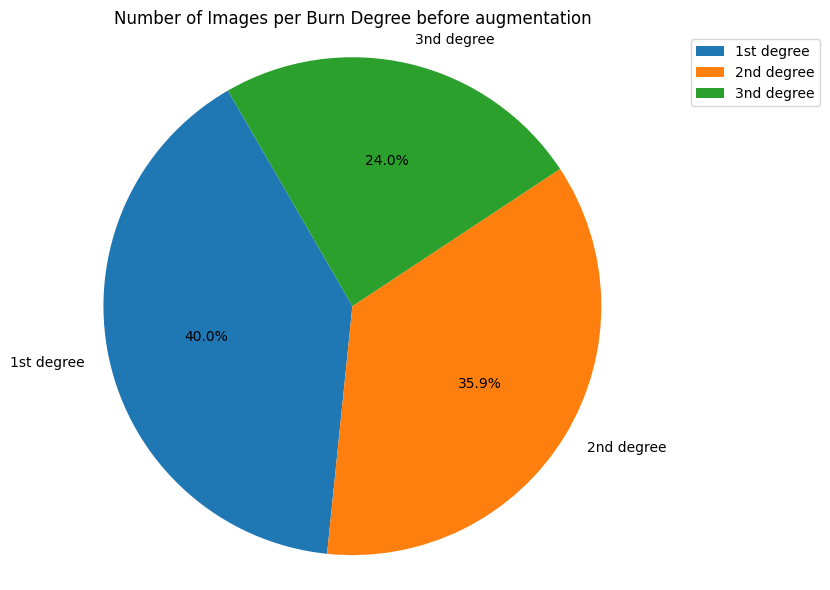

In [6]:
folder_paths1 = [
    '/kaggle/input/burn-dataset13/last_databurn/1st degree',
    '/kaggle/input/burn-dataset13/last_databurn/2nd degree',
    '/kaggle/input/burn-dataset13/last_databurn/3nd degree'
]

extension = 'jpg'
photo_counts = []

for folder_path in folder_paths1:
    photo_count = sum(1 for filename in os.listdir(folder_path)
                      if filename.lower().endswith(f".{extension}"))
    photo_counts.append(photo_count)

# Create class labels based on folder names
class_label = [os.path.basename(path) for path in folder_paths1]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(photo_counts, labels=class_label, autopct="%1.1f%%", startangle=120)
plt.title("Number of Images per Burn Degree before augmentation", fontsize=12)

plt.axis('equal')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [7]:
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
def augment_images(input_directory, output_directory, augmentation_factor):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # Initialize the ImageDataGenerator with desired augmentations
    datagen = ImageDataGenerator(
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
    )
    # Load and augment the original images
    image_files = os.listdir(input_directory)
    def load_and_preprocess_image(image_path):
        # Load the image from the specified path
        img = cv2.imread(image_path)
        # You can add any preprocessing steps here as needed
        # For example, resizing the image to a specific size
        img = cv2.resize(img, (224, 224))  # Replace target_width and target_height
        return img
    for image_file in image_files:
        image_path = os.path.join(input_directory, image_file)
        img = load_and_preprocess_image(image_path)  # Load and preprocess your image as needed
        # Reshape to (1, height, width, channels) for the generator
        img = img.reshape((1,) + img.shape)
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_image = batch[0].astype('uint8')
            augmented_filename = f"{os.path.splitext(image_file)[0]}_augmented_{i}.jpg"
            augmented_image_path = os.path.join(output_directory, augmented_filename)
            cv2.imwrite(augmented_image_path, augmented_image)
            i += 1
            if i >= augmentation_factor:
                break
# Example usage:
input_directory = '/kaggle/input/burn-dataset13/last_databurn/1st degree'
output_directory = '/kaggle/working/collect_data_withaug/1'
augmentation_factor = 5
augment_images(input_directory, output_directory, augmentation_factor)
input_directory = '/kaggle/input/burn-dataset13/last_databurn/2nd degree'
output_directory = '/kaggle/working/collect_data_withaug/2'
augmentation_factor = 5
augment_images(input_directory, output_directory, augmentation_factor)
input_directory = '/kaggle/input/burn-dataset13/last_databurn/3nd degree'
output_directory = '/kaggle/working/collect_data_withaug/3'
augmentation_factor = 6
augment_images(input_directory, output_directory, augmentation_factor)

In [8]:
folder_path = '/kaggle/working/collect_data_withaug/1'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 1st Degree folder is: {photo_count}')
folder_path = '/kaggle/working/collect_data_withaug/2'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 2nd Degree folder is: {photo_count}')
folder_path = '/kaggle/working/collect_data_withaug/3'
extension = 'jpg'
photo_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(f".{extension}"))
print(f'The number of {extension} files in the 3rd Degree folder is: {photo_count}')

The number of jpg files in the 1st Degree folder is: 3258
The number of jpg files in the 2nd Degree folder is: 2927
The number of jpg files in the 3rd Degree folder is: 2282


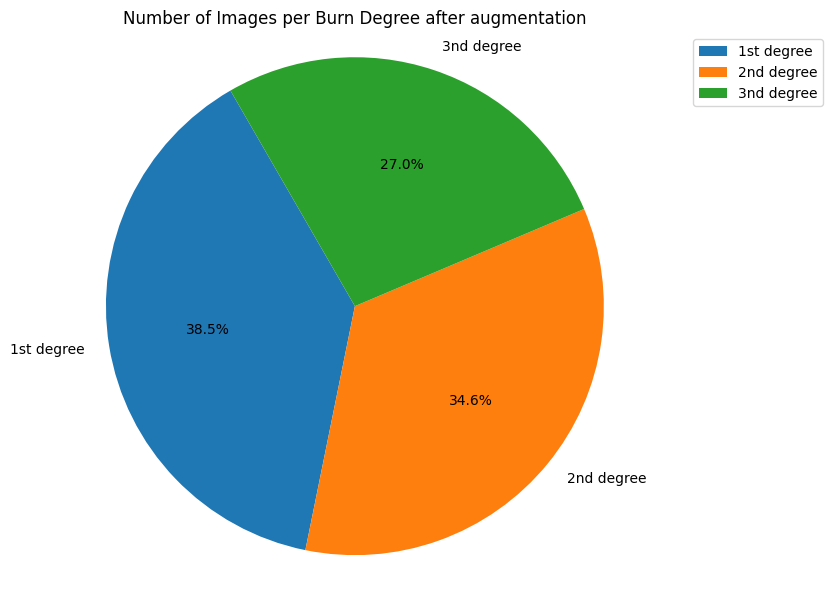

In [9]:
folder_paths = [
    '/kaggle/working/collect_data_withaug/1',
    '/kaggle/working/collect_data_withaug/2',
    '/kaggle/working/collect_data_withaug/3'
]

extension = 'jpg'
photo_counts = []
for folder_path in folder_paths:
    photo_count = sum(1 for filename in os.listdir(folder_path)
                      if filename.lower().endswith(f".{extension}"))
    photo_counts.append(photo_count)

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(photo_counts, labels=class_label, autopct="%1.1f%%", startangle=120)
plt.title("Number of Images per Burn Degree after augmentation", fontsize=12)

plt.axis('equal')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [10]:
labels = ['1','2','3']


In [11]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/working/collect_data_withaug',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 2282/2282 [00:01<00:00, 1642.04it/s]


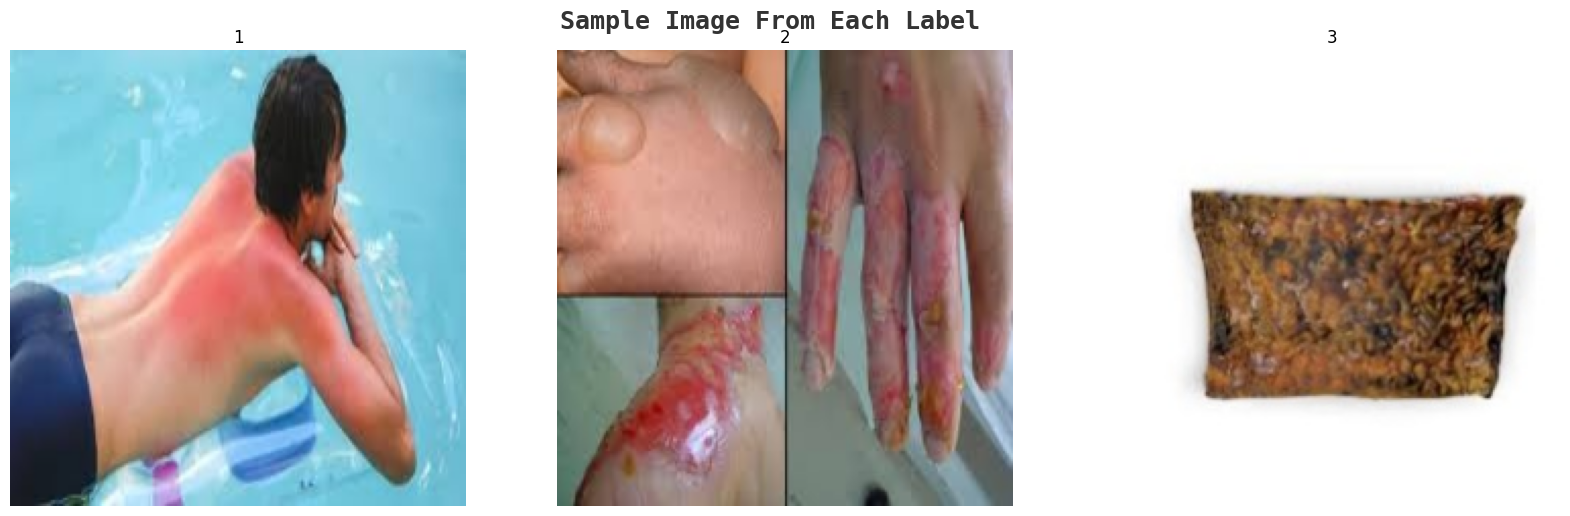

In [12]:
import random

k = 0
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold',
         fontname='monospace', y=0.62, x=0.4, alpha=0.8)

for i in labels:
    label_indices = [j for j in range(len(y_train)) if y_train[j] == i]
    random_index = random.choice(label_indices)

    ax[k].imshow(X_train[random_index])
    ax[k].set_title(y_train[random_index])
    ax[k].axis('off')
    k += 1


In [13]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [15]:
X_train_scaled=X_train/255

In [16]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# effecinet

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [18]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [19]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [20]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [21]:
EPOCHS = 65
BATCH_SIZE = 32
best_model_dir = '/kaggle/working/'

os.makedirs(best_model_dir, exist_ok=True)

model_checkpoint = ModelCheckpoint(
    os.path.join(best_model_dir, 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train,y_train, validation_data=(X_test, y_test),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=[model_checkpoint ,early_stopping])

Epoch 1/65
212/212 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7721
Epoch 1: val_loss improved from inf to 0.58233, saving model to /kaggle/working/best_model.keras
212/212 [==============================] - 297s 1s/step - loss: 0.5524 - accuracy: 0.7721 - val_loss: 0.5823 - val_accuracy: 0.8099
Epoch 2/65
212/212 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8986
Epoch 2: val_loss improved from 0.58233 to 0.39194, saving model to /kaggle/working/best_model.keras
212/212 [==============================] - 255s 1s/step - loss: 0.2699 - accuracy: 0.8986 - val_loss: 0.3919 - val_accuracy: 0.8861
Epoch 3/65
212/212 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9247
Epoch 3: val_loss improved from 0.39194 to 0.34587, saving model to /kaggle/working/best_model.keras
212/212 [==============================] - 253s 1s/step - loss: 0.2047 - accuracy: 0.9247 - val_loss: 0.3459 - val_accuracy: 0.8926
Epoch 4/65
212/21

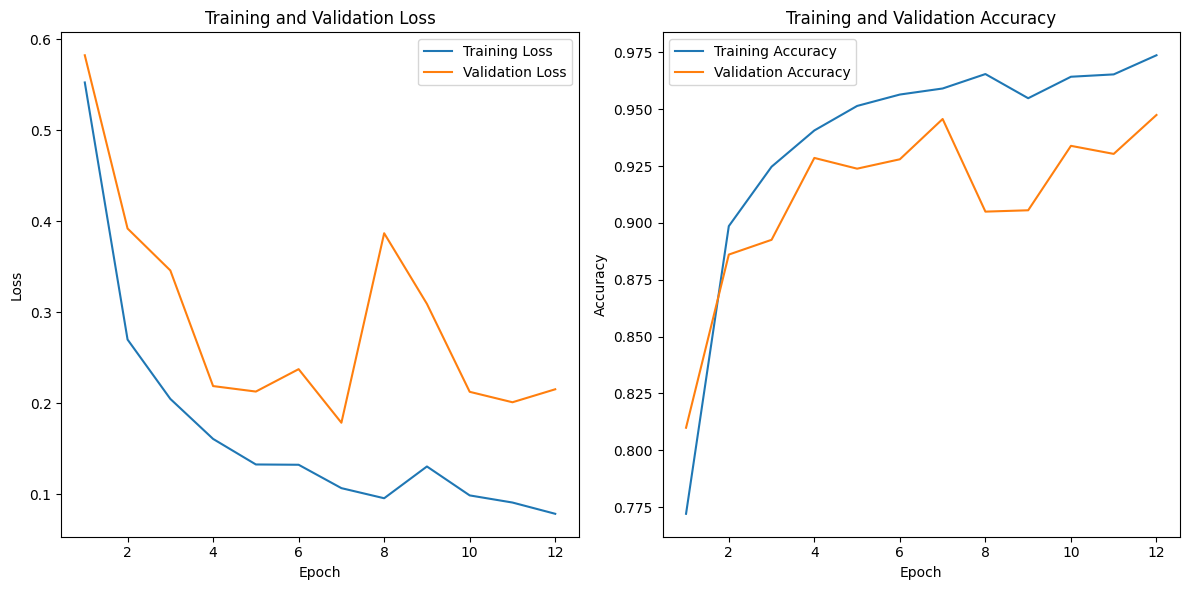

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
model.save('/kaggle/working/my_model_eff2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from tensorflow.keras.models import load_model

loaded_model_eff = load_model('/kaggle/working/my_model_eff2.h5')

In [25]:
y_pred=loaded_model_eff.predict(X_test)
print(y_pred)
import numpy as np
z=np.argmax(y_pred, axis=1) #return index of the large number
z

53/53 [==============================] - 14s 242ms/step
[[3.22966276e-09 9.99999940e-01 7.53697105e-09]
 [8.67011386e-06 1.60622832e-04 9.99830723e-01]
 [9.99993980e-01 1.74251056e-06 4.21453797e-06]
 ...
 [9.99999881e-01 1.60269039e-07 1.52775179e-08]
 [9.99836445e-01 1.62578508e-04 1.01084379e-06]
 [3.38852894e-03 1.22329496e-01 8.74282002e-01]]


array([1, 2, 0, ..., 0, 0, 2])

In [26]:
y_test_ = np.argmax(y_test, axis=1)

print(y_test_)

[1 2 0 ... 0 0 2]


In [27]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_, z))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       672
           1       0.91      0.95      0.93       557
           2       0.98      0.92      0.95       465

    accuracy                           0.95      1694
   macro avg       0.95      0.94      0.95      1694
weighted avg       0.95      0.95      0.95      1694



[[647  24   1]
 [ 18 530   9]
 [  9  28 428]]


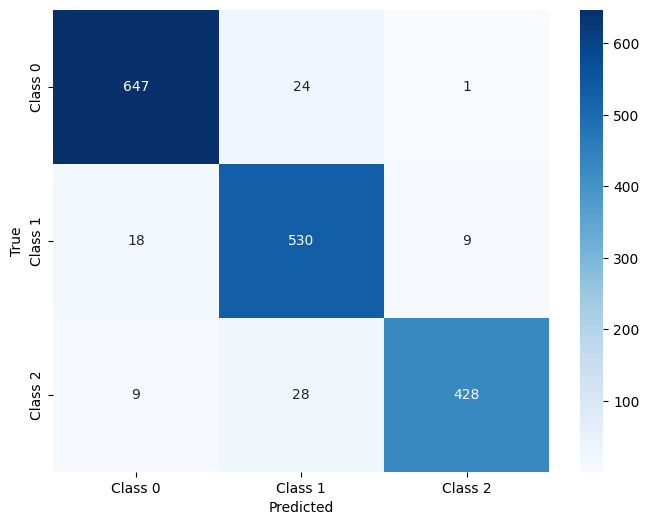

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_mat = confusion_matrix(y_test_, z)
print(conf_mat)
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load EfficientNetB0 for feature extraction (exclude the top fully connected layer)
base_model = EfficientNetB0(include_top=False, pooling='avg')

# Function to preprocess the input image and resize it to 224x224 (required for EfficientNetB0)
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # EfficientNetB0 expects 224x224 images
    img_array = img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to extract features using EfficientNetB0
def extract_features(img_array):
    features = base_model.predict(img_array)
    print(f"Extracted features shape: {features.shape}")  # Debugging output
    return features

# Example image path for testing
img_path = '/kaggle/input/burn-dataset13/last_databurn/3nd degree/google_0238.jpg'

# Preprocess and extract features
img_array = preprocess_image(img_path)
features = extract_features(img_array)

1/1 [==============================] - 1s 1s/step
Extracted features shape: (1, 1280)


In [31]:
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Type of X_train_scaled: {type(X_train_scaled)}")


Shape of X_train_scaled: (6774, 224, 224, 3)
Type of X_train_scaled: <class 'numpy.ndarray'>


Saving first (2).jpg to first (2).jpg
1/1 [==============================] - 1s 1s/step


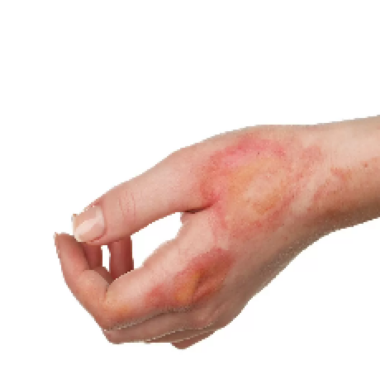

Predicted class: second degree
Confidence score: 0.96


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from google.colab import files  # If using Google Colab

# Load the trained model
model = tf.keras.models.load_model('/kaggle/working/best_model.keras')

# Define the threshold for confidence
confidence_threshold = 0.7

# Upload image directly from the system
uploaded = files.upload()  # This will prompt an upload dialog
img_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image

# Load and preprocess the image
img_size = 224  # EfficientNetB0 expects 224x224 images
img = image.load_img(img_path, target_size=(img_size, img_size))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess as per EfficientNet's requirements

# Make predictions
predictions = model.predict(img_array)

# Get the maximum confidence score and its corresponding class index
confidence_scores = predictions[0]
max_confidence = np.max(confidence_scores)
predicted_class = np.argmax(confidence_scores)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Check if the maximum confidence score is above the threshold
if max_confidence >= confidence_threshold:
    # If the confidence score is above the threshold, classify the burn degree
    class_names = ['first degree', 'second degree', 'third degree']
    print(f'Predicted class: {class_names[predicted_class]}')
    print(f'Confidence score: {max_confidence:.2f}')
else:
    # If the confidence score is below the threshold, consider it as a non-burn image
    print('The image is Non-Burn')


In [45]:
model.save('/kaggle/working/my_model_eff2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
from google.colab import files
files.download('/kaggle/working/my_model_eff2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>